In [1]:
#import
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import shap

In [2]:
#Reading dataset
df=pd.read_csv('DFT_ESP.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cate_name          68 non-null     object 
 1   Cate_HOMO          68 non-null     float64
 2   Cate_LUMO          68 non-null     float64
 3   Cate_ESP_O1        68 non-null     float64
 4   Cate_ESP_H1        68 non-null     float64
 5   Cate_ESP_O2        68 non-null     float64
 6   Cate_ESP_H2        68 non-null     float64
 7   Cate_BL_ArO1       68 non-null     float64
 8   Cate_BL_O1H1       68 non-null     float64
 9   Cate_BL_ArO2       68 non-null     float64
 10  Cate_BL_O2H2       68 non-null     float64
 11  Cate_total_dipole  68 non-null     float64
 12  P_name             68 non-null     object 
 13  P_HOMO             68 non-null     float64
 14  P_LUMO             68 non-null     float64
 15  P_ESP_P            68 non-null     float64
 16  P_ESP_=O           68 non-nu

In [3]:
#Building descriptors
X = df.drop(columns=['Yield', 'Cate_name', 'P_name' ])
print('---Descriptors---')
print(X.head())

y = pd.DataFrame(df['Yield'],columns=['Yield'])
y=y.astype(int)
print('---Objective---')
print(y.head())

---Descriptors---
   Cate_HOMO  Cate_LUMO  Cate_ESP_O1  Cate_ESP_H1  Cate_ESP_O2  Cate_ESP_H2  \
0      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
1      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
2      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
3      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
4      -5.51       0.22    -0.542028     0.433177    -0.582447     0.440296   

   Cate_BL_ArO1  Cate_BL_O1H1  Cate_BL_ArO2  Cate_BL_O2H2  Cate_total_dipole  \
0         1.363         0.969         1.378         0.965           2.484773   
1         1.363         0.969         1.378         0.965           2.484773   
2         1.363         0.969         1.378         0.965           2.484773   
3         1.363         0.969         1.378         0.965           2.484773   
4         1.364         0.969         1.379         0.965           2.303134   

   P_HOMO  P_LUMO   P_ESP_

In [4]:
print(X.info())
print(X.isnull().any())
print(X.isnull().values.sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cate_HOMO          68 non-null     float64
 1   Cate_LUMO          68 non-null     float64
 2   Cate_ESP_O1        68 non-null     float64
 3   Cate_ESP_H1        68 non-null     float64
 4   Cate_ESP_O2        68 non-null     float64
 5   Cate_ESP_H2        68 non-null     float64
 6   Cate_BL_ArO1       68 non-null     float64
 7   Cate_BL_O1H1       68 non-null     float64
 8   Cate_BL_ArO2       68 non-null     float64
 9   Cate_BL_O2H2       68 non-null     float64
 10  Cate_total_dipole  68 non-null     float64
 11  P_HOMO             68 non-null     float64
 12  P_LUMO             68 non-null     float64
 13  P_ESP_P            68 non-null     float64
 14  P_ESP_=O           68 non-null     float64
 15  P_ESP_H            68 non-null     float64
 16  P_BL_P=O           68 non-nu

In [5]:
#storage 
data_r2_train =[]
data_RMSE_train = []
data_MAE_train = []
data_r2_test = []
data_RMSE_test = []
data_MAE_test = []
best_model_parametors = []
data_cv_score = []
cum_imp=pd.Series(index = X.columns)
cum_imp.fillna(0, inplace=True)

#RF_a_X
for i in range(10):
    seed=i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)

    param_grid = {"max_depth":[2,3,4,5],
                  'n_estimators':[1000,3000,5000]}
    reg_rf = GridSearchCV(RandomForestRegressor(random_state=0), param_grid=param_grid, cv=5, n_jobs=3)
    reg_rf.fit(a_X_train,y_train['Yield'])
    reg_best = reg_rf.best_estimator_
    y_pred1 = reg_best.predict(a_X_train)
    y_pred2 = reg_best.predict(a_X_test)
            
    #train
    r2_train = metrics.r2_score(y_train, y_pred1)
    RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
    MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
    #test
    r2_test = metrics.r2_score(y_test, y_pred2)
    RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
    MAE_test = metrics.mean_absolute_error(y_test, y_pred2)

    parametors = reg_rf.best_params_
    best_model_parametors.append(parametors)

    data_r2_train.append(r2_train)
    data_RMSE_train.append(RMSE_train)
    data_MAE_train.append(MAE_train)
    data_r2_test.append(r2_test)
    data_RMSE_test.append(RMSE_test)
    data_MAE_test.append(MAE_test)
    data_cv_score.append(reg_rf.best_score_)
    
    #cumulative importances 
    importances = pd.Series(reg_best.feature_importances_, index = X.columns)
    cum_imp += importances
    
    print('----------------------')
    print('seed:', seed)
    print("Best Model Parameter:",reg_rf.best_params_)
    print("Best Model Score:",reg_rf.best_score_)
    print('R2_test:', r2_test)
print('R2_train_means:', sum(data_r2_train)/10)
print('CV_score_means:', sum(data_cv_score)/10)
print('R2_test_means:', sum(data_r2_test)/10)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


----------------------
seed: 0
Best Model Parameter: {'max_depth': 2, 'n_estimators': 5000}
Best Model Score: 0.8231411629570242
R2_test: 0.7068305395413725
----------------------
seed: 1
Best Model Parameter: {'max_depth': 5, 'n_estimators': 1000}
Best Model Score: 0.7064857126947582
R2_test: 0.8361842392188293
----------------------
seed: 2
Best Model Parameter: {'max_depth': 2, 'n_estimators': 5000}
Best Model Score: 0.7534966039437335
R2_test: 0.795690104638589
----------------------
seed: 3
Best Model Parameter: {'max_depth': 2, 'n_estimators': 3000}
Best Model Score: 0.774218703211906
R2_test: 0.706189079129786
----------------------
seed: 4
Best Model Parameter: {'max_depth': 2, 'n_estimators': 3000}
Best Model Score: 0.7572826248782386
R2_test: 0.8028666626992886
----------------------
seed: 5
Best Model Parameter: {'max_depth': 3, 'n_estimators': 3000}
Best Model Score: 0.8030401480111806
R2_test: 0.8134558960491702
----------------------
seed: 6
Best Model Parameter: {'max_de

In [6]:
data_r2_train_pd = pd.DataFrame(data= data_r2_train, columns=['r2_train'])
data_RMSE_train_pd = pd.DataFrame(data=data_RMSE_train, columns=['RMSE_train'])
data_MAE_train_pd = pd.DataFrame(data=data_MAE_train, columns=['MAE_train'])
data_r2_test_pd = pd.DataFrame(data=data_r2_test, columns=['r2_test'])
data_RMSE_test_pd = pd.DataFrame(data=data_RMSE_test, columns=['RMSE_test'])
data_MAE_test_pd = pd.DataFrame(data=data_MAE_test, columns=['MAE_test'])
data_cv_score_pd = pd.DataFrame(data=data_cv_score, columns=['cv_score'])
data_parametors = pd.DataFrame([best_model_parametors])

data_all = pd.concat([data_r2_train_pd, data_RMSE_train_pd, data_MAE_train_pd, data_r2_test_pd, 
                      data_RMSE_test_pd, data_MAE_test_pd, data_cv_score_pd],
                     axis=1, join='inner')

data_all.loc['mean'] = data_all.mean()
print(data_all)

data_all.to_csv('../../score/DFT/RF_score.csv')
#data_parametors.to_csv('/Users/nata/Documents/ML/amidation/score/DFT/DFT_ESP/RF/parametors.csv')

      r2_train  RMSE_train  MAE_train   r2_test   RMSE_test   MAE_test  \
0     0.903817   70.912689   5.400605  0.706831  383.451029  12.287271   
1     0.956985   38.899012   3.687424  0.836184  158.712584   8.637923   
2     0.871910  118.496297   6.612125  0.795690  197.580178   8.319160   
3     0.880242  111.699755   6.253396  0.706189  281.983865  10.302542   
4     0.849860  129.435113   6.941826  0.802867  209.616661   8.680966   
5     0.920224   64.597308   4.766104  0.813456  226.875701   9.786456   
6     0.881725   97.065289   6.045459  0.772252  274.085115  10.274377   
7     0.877600  117.075373   6.706119  0.751790  225.004266   9.124486   
8     0.923047   67.727354   4.673061  0.727069  269.719968  11.215945   
9     0.835616  166.593431   8.029708  0.896744   72.760215   5.323896   
mean  0.890103   98.250162   5.911583  0.780907  229.978958   9.395302   

      cv_score  
0     0.823141  
1     0.706486  
2     0.753497  
3     0.774219  
4     0.757283  
5     0.8

In [5]:
seed=9
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)

    
param_grid = {"max_depth":[2,3,4,5],'n_estimators':[1000,3000,5000]}
reg_rf = GridSearchCV(RandomForestRegressor(random_state=0), param_grid=param_grid, cv=5, n_jobs=3)
reg_rf.fit(a_X_train,y_train['Yield'])
reg_best = reg_rf.best_estimator_
y_pred1 = reg_best.predict(a_X_train)
y_pred2 = reg_best.predict(a_X_test)
            
r2_train = metrics.r2_score(y_train, y_pred1)
r2_test = metrics.r2_score(y_test, y_pred2)
print('r2_train:',r2_train)
print('r2_test:',r2_test)

r2_train: 0.8356164081078189
r2_test: 0.8967438715157292


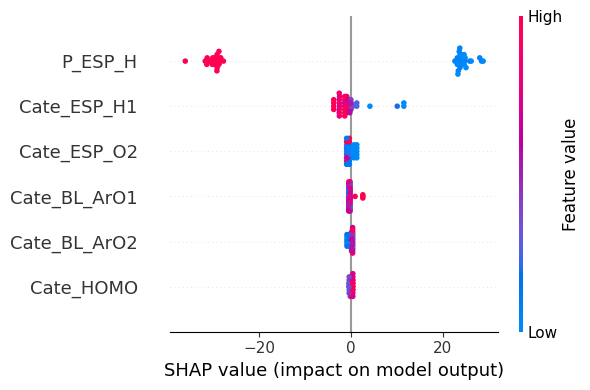

In [6]:
#shap
explainer = shap.TreeExplainer(reg_best)
shap_values = explainer.shap_values(X=a_X_train)
shap.summary_plot(shap_values, a_X_train, max_display=6, plot_size=(6, 4))